## **CIS5231 - Topics in Applied Data Science**
### Coursework - Sentiment Analysis
---

In [1]:
# Loading libraries

import pandas as pd
import numpy as np
import random
import time
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import nltk


from imblearn.under_sampling import RandomUnderSampler # for random undersampling , can be installed with pip install imbalanced-learn
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting wider column width 
pd.set_option("max_colwidth", 100)

In [3]:
# If running from scratch set this to True
# If set to False a later algorithm will try to load the saved pickle files
RUN_FROM_SCRATCH = True

### **The Tasks**

#### **Task 1**

In [4]:
# For reproducabitily 

np.random.seed(2024)
random.seed(2024)

SEED = 2024

In [5]:
# Loading the dataset

df = pd.read_csv('SAR14.txt', header = None, names=['review', 'rating'])

In [6]:
# Checking a sample of 5 rows from the dataset

df.sample(5)

,review,rating
129817,great . i love this film i remember the cartoons growing up tonight i watched the movie it was ...,10
224149,Ghost of Girlfriend 's Past was actually touching . At first I really disliked this movie . I h...,7
51629,The Godfather of the 90s ... ... . This movie is really cool I like all of the caracters . Matt...,10
112009,Great film for pre-teen girls . Good dubbing for a change . . Though not as entertaining for re...,10
24053,The Style of Bu uel . Luis Bu uel 's The Phantom of Liberty brought a new profound perspective ...,9


First let us check if we have any empty reviews or ratings.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233600 entries, 0 to 233599
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  233600 non-null  object
 1   rating  233600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
df[df.review.isnull()]

,review,rating


The dataframe does not seem to have any empty cells. 

Let's have a loook at the first two reviews in full. 

In [9]:
df.review[0]

" The first art-film ? . this is possibly the most beautiful of the early Lumiere shorts . A boat rows from the front of the screen away from the audience to the back , while to the right , women wait on the port . The camera , as usual , does not move , but the play of sunlight on the waves are gorgeous , and the rippling movement is so vibrant , especially within such a static frame , that it looks like one is watching an actual scene behind glass . As with ` Demolition d'un mur ' , the real frisson of the film comes from the unexpected . The scene proceeds as expected , the boat moving steadily along . But , just as it turns , a stronger wave lunges , and almost capsizes the boat . Before we discover what will happen , the reel , and the film , ends . These early films made no precautions for the necessity of extra reels . But the effect is quite shocking . The unexpected violence is unsettling enough , but with the film over , and loose ends nowhere near being tied up - indeed , ju

In [10]:
df.review[1]

" collision between the tradition of family values , the modernity of the new medium , and the inscrutability of nature . . Two loving parents feed their happy baby on the perch of their country home . It is often said that these early Lumiere shorts are primitive because they have not yet mastered basic film grammar , such as camera movement , editing or the close-up , films like these being a simple , static set-u ; , the camera pointing at the scene from a middle distance . But as filmmakers like Godard , Ozu and Kitano , for instance , realized , that very grammar can be a violation of the integrity of the image , forcing us to concentrate of the structure in which the image is only a unit , rather than the image itself . There is nothing primitive or simple about this particular image ; as critics have noted , this film offers two levels of movement , one human , recognisable , communal -LRB- the family -RRB- ; the other -LRB- the trees blowing -RRB- part of a different order alto

It seems that the only pre-processing done on the text is to ensure each word is separated by a whitespace, ensuring that hyphenated words are retained as a concatenated word. No lowercasing has been performed, no stop word removal nor punctuation removals. For the eventual tokenization we can hence use the whitespace as the separator. Some spelling mistakes can also be noted and these might not be picked up when using lexicons such as WordtoVec or GloVE. 

#### **Task 2**

I will start by first converting the rating into a postive or negative sentiment. 

In [11]:
# Creating a new column with just a -1/1 value for sentiment rating
def get_sentiment(x):
    if x > 5:
        return 1
    return -1

In [12]:
df['sentiment'] = df['rating'].apply(get_sentiment)

I will create 4 copies of the original dataframe to perform the requested processing: <br>

- **df_1** : Dataframe where the review contains only tokenized text (removing all words that have punctuation or numerical data)
- **df_2** : Dataframe as df_1 but with stop word removal
- **df_3** : Dataframe as df_1 but with lemmatisation applied
- **df_4** : Dataframe as df_1 but with both stop word removal and lemmatisation applied. 

#### *df_1*

In [13]:
# Creating a copy of the original dataframe
df_1 = df.copy()

In [14]:
# Lowercase all the text
df_1['review'] = [entry.lower() for entry in df_1['review']]

In [15]:
# Tokenisation, create the review entry into a list of words
df_1['review'] = [WhitespaceTokenizer().tokenize(entry) for entry in df_1['review']]

In [16]:
for index,entry in enumerate(df_1['review']):
    
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    
    for word in entry:
    
        # Below condition is to consider only alphabets
        if word.isalpha():
            word_Final = word
            Final_words.append(word_Final)
    
    # The final processed set of words for each iteration will be stored in 'final_review'
    df_1.loc[index,'final_review'] = str(Final_words)

In [17]:
df_1.head()

,review,rating,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",10,1,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",10,1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",4,-1,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",4,-1,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",8,1,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


We will encode the target feature to values 0 for a negative review and 1 for a positive review. We also drop the rating column as we do not need it. 

In [18]:
# Encoding target labels in range [0..(n_classes - 1)]
encoder = LabelEncoder()

In [19]:
# Applying the encoder to the sentiment column
df_1.sentiment = encoder.fit_transform(df_1.sentiment)

In [20]:
# Dropping the rating column as we no longer need it
df_1.drop('rating', axis=1, inplace = True)

In [21]:
df_1.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


In [22]:
# Savingthe DataFrame using pickle
with open('df_1.pkl', 'wb') as f:
    pickle.dump(df_1, f)

#### *df_2*

In [23]:
df_2 = df.copy()

In [24]:
# Lowercase all the text
df_2['review'] = [entry.lower() for entry in df_2['review']]

In [25]:
# Tokenisation, create the review entry into a list of words
df_2['review'] = [WhitespaceTokenizer().tokenize(entry) for entry in df_2['review']]

In [26]:
# Setting the stopwords (from NLTK)
sw = set(stopwords.words('english'))

for index,entry in enumerate(df_2['review']):

    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    
    for word in entry:
        # Below condition is to check for Stop words and consider only alphabets
        if word not in sw and word.isalpha():
            word_Final = word
            Final_words.append(word_Final)
    
    # The final processed set of words for each iteration will be stored in 'text_final'
    df_2.loc[index,'final_review'] = str(Final_words)

In [27]:
df_2.head()

,review,rating,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",10,1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'shorts', 'boat', 'rows', 'front', 'scree..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",10,1,"['collision', 'tradition', 'family', 'values', 'modernity', 'new', 'medium', 'inscrutability', '..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",4,-1,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",4,-1,"['first', 'family', 'film', 'monsieur', 'lumi', 'wants', 'us', 'know', 'one', 'talented', 'filmm..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",8,1,"['ouch', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'back', 'commenting', 'silent', 'f..."


In [28]:
# Applying the encoder to the sentiment column
df_2.sentiment = encoder.fit_transform(df_2.sentiment)

In [29]:
# Dropping the rating column as we no longer need it
df_2.drop('rating', axis=1, inplace = True)

In [30]:
df_2.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'shorts', 'boat', 'rows', 'front', 'scree..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'tradition', 'family', 'values', 'modernity', 'new', 'medium', 'inscrutability', '..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['first', 'family', 'film', 'monsieur', 'lumi', 'wants', 'us', 'know', 'one', 'talented', 'filmm..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'back', 'commenting', 'silent', 'f..."


In [31]:
# Savingthe DataFrame using pickle
with open('df_2.pkl', 'wb') as f:
    pickle.dump(df_2, f)

### *df_3*

In [32]:
df_3 = df_1.copy()

In [33]:
df_3.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


In [34]:
# WordNetLemmatizer requires POS tags
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Initializing WordNetLemmatizer()
word_Lemmatized = WordNetLemmatizer()

In [35]:
tag_map

defaultdict(<function __main__.<lambda>()>, {'J': 'a', 'V': 'v', 'R': 'r'})

In [36]:
pos_tag(df_1.review[0])[:15]

[('the', 'DT'),
 ('first', 'JJ'),
 ('art-film', 'NN'),
 ('?', '.'),
 ('.', '.'),
 ('this', 'DT'),
 ('is', 'VBZ'),
 ('possibly', 'RB'),
 ('the', 'DT'),
 ('most', 'RBS'),
 ('beautiful', 'JJ'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('early', 'JJ'),
 ('lumiere', 'JJ')]

https://medium.com/@yashj302/lemmatization-f134b3089429  <br>

We have set a dictionary to map Part of Speech (POS) tags identified by NLTK to the format expected by the WordNetLemmatizer. WordNet is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations. So for example if the NLTK identifies the word 'is' as VBZ, this is mapped to the 'v' in WordNetLemmatizer.  <br>

The code below loops through the dataframe rows, extracting the review as a list. It then iterates over each word in the list, extracts its part of speech (pos) tag and if the word is alpha (i.e. no numerical data or punctuation) it gets that word and its tag, reads the first letter of the tag and matches it to the respective WordNet tag (by using the tag_map dictionary). In default of matching any of the pre-set letters, it will tag the word as a noun. It then gets the lemma of that word and appends it to a list that is then set as the lemmatized list for that row. 

In [37]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kcini75/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

I will be using the column 'final_review' as this already contains the words that have been processed to remove numerical data and punctuation. As the content of each record is a string I will convert it to a list using the method *eval()* to be able to iterate over the strings inside the list. 

In [38]:
for index,entry in enumerate(df_3['final_review']):
    
    entry = eval(entry) # we use eval here to convert the string contained in 'final_review' to a list
    
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    
    for word, tag in pos_tag(entry):
        word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
        Final_words.append(word_Final)
    
    # The final processed set of words for each iteration will be stored in 'final_review'
    df_3.loc[index,'final_review'] = str(Final_words)    

In [39]:
df_3.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'be', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'value', 'the', 'modernity', 'of', ..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'want', 'u', 'to', '..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'get', 'ta', 'hurt', 'spoiler', 'spoiler', 'well', 'i', 'be', 'back', 'to', 'co..."


In [40]:
# Savingthe DataFrame using pickle
with open('df_3.pkl', 'wb') as f:
    pickle.dump(df_3, f)

### *df_4*

In [41]:
df_4 = df_2.copy()

In [42]:
for index,entry in enumerate(df_4['final_review']):
    
    entry = eval(entry)
    
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    
    for word, tag in pos_tag(entry):
        word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
        Final_words.append(word_Final)
    
    # The final processed set of words for each iteration will be stored in 'text_final'
    df_4.loc[index,'final_review'] = str(Final_words)

In [43]:
df_4.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'short', 'boat', 'row', 'front', 'screen'..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'tradition', 'family', 'value', 'modernity', 'new', 'medium', 'inscrutability', 'n..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['first', 'family', 'film', 'monsieur', 'lumi', 'want', 'u', 'know', 'one', 'talented', 'filmmak..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'get', 'ta', 'hurt', 'spoiler', 'spoiler', 'well', 'back', 'comment', 'silent', 'film',..."


In [44]:
# Savingthe DataFrame using pickle
with open('df_4.pkl', 'wb') as f:
    pickle.dump(df_4, f)

#### Loading directly the saved datasets

In [45]:
if not RUN_FROM_SCRATCH:

    with open('df_1.pkl', 'rb') as f:
        df_1 = pickle.load(f)

    with open('df_2.pkl', 'rb') as f:
        df_2 = pickle.load(f)

    with open('df_3.pkl', 'rb') as f:
        df_3 = pickle.load(f)

    with open('df_4.pkl', 'rb') as f:
        df_4 = pickle.load(f)


#### **Task 3**

Let us first examine the proportion of negative and positive reviews in our dataset.

In [46]:
df_1.sentiment.value_counts()

sentiment
1    167378
0     66222
Name: count, dtype: int64

Visualizing this as a countplot. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


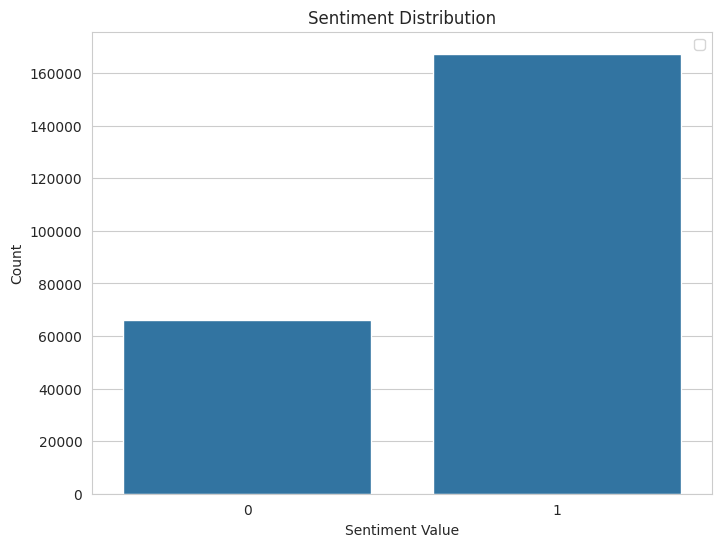

In [47]:
# Set style
sns.set_style("whitegrid")

# Creating plot
plt.figure(figsize=(8, 6))
sns.countplot(df_1, x='sentiment');

plt.xlabel('Sentiment Value')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.legend()
plt.show()

In [48]:
print(f'Out of the total number of reviews {(df_1.sentiment.value_counts()[1] / len(df_1)):.2%} are positive and {(df_1.sentiment.value_counts()[0] / len(df_1)):.2%} are negative')

Out of the total number of reviews 71.65% are positive and 28.35% are negative


One can note a clear imbalance between positive and negative reviews, with positive reviews more than double the negative ones. This may influence our classifier algorithms in having more samples from the positive reviews. This may result in the classifiers making a positive review prediction when the actual review would be negative, i.e. instances of false positives. This would also be reflected in a disparity between the accuracy score and the F1 score. We hence also expect to have a higher recall score (identifying a large proportoin of true positives out of all actual positive instances) as opposed to precision where we expect a lower score given that the classifier will tend to predict a positive review when actually the review would be negative).

#### **Task 4**

In [49]:
df_1.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


Splitting between training and testing sets. 

In [50]:
# Initializing the vectorizer

tfidf_vect = TfidfVectorizer(max_features=5000)

In [51]:
def split_dataset(dataset, tfidf_vect, test_size = 0.3):
    
    '''
    Input: dataframe containing the data that needs to be split into training and testing, initialized vectorizer
    Output : training set and testing set in the required proportion
    '''
        
    # Setting X and y
    X = dataset['final_review']
    y = dataset['sentiment'].values
    
    # Splitting dataset
    train_X, test_X, train_Y, test_Y = model_selection.train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)
    
    # Vectorizing
    tfidf_vect.fit(X)

    train_X_tfidf = tfidf_vect.transform(train_X)
    test_X_tfidf = tfidf_vect.transform(test_X)
    
    return train_X_tfidf, train_Y, test_X_tfidf, test_Y    

It is to be noted that tfidf vectorizer is being fitted on the whole training set. 

In [52]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_1, tfidf_vect)

In [53]:
# Checking proper stratification of train_Y and test_Y

print(f'train_Y has : {(np.unique(train_Y, return_counts=True)[1][0] / len(train_Y)):.2%} of negative reviews and : {(np.unique(train_Y, return_counts=True)[1][1] / len(train_Y)):.2%} of positive reviews')
print(f'test_Y has : {(np.unique(test_Y, return_counts=True)[1][0] / len(test_Y)):.2%} of negative reviews and : {(np.unique(test_Y, return_counts=True)[1][1] / len(test_Y)):.2%} of positive reviews')

train_Y has : 28.35% of negative reviews and : 71.65% of positive reviews
test_Y has : 28.35% of negative reviews and : 71.65% of positive reviews


Stratification has been applied correctly. 

For easier retrieval and code reusal, I will create two functions that will be used to train and evaluate the requested models. 

#### *Naive Bayes Classifier*

In [54]:
def naive_bayes_evaluation(model, train_X, train_Y, test_set):
    
    '''
    Input: the classifier, training set (X and y), test set
    Output: Accuracy, Precision, recall and F1 metrics for the model predictions
            Confusion Matrix
    '''
    
    # Training
    model.fit(train_X, train_Y)
    
    # Prediction
    predictions = model.predict(test_set)
    
    # Evaluation - Confusion Matrix
    TP, TN, FP, FN = plot_cm('Naive_Bayes', test_Y, predictions )
    
    # Evaluation - Metrics
    
    accuracy = accuracy_score(predictions, test_Y)
    precision = precision_score(test_Y, predictions)
    recall = recall_score(test_Y, predictions)
    f1 = f1_score(test_Y, predictions)
    
    return TP, TN, FP, FN, accuracy, precision, recall , f1

#### *Support Vector Machine Classifier*

In [55]:
def svm_evaluation(model, train_X, train_Y, test_set):
    
    '''
    Input: the classifier, training set (X and y), test set
    Output: Accuracy, Precision, recall and F1 metrics for the model predictions
            Confusion Matrix
    '''
    
    # Training
    model.fit(train_X, train_Y)
    
    # Prediction
    predictions = model.predict(test_set)
    
    # Evaluation - Confusion Matrix
    TP, TN, FP, FN = plot_cm('SVM', test_Y, predictions)

    # Evaluation - Metrics
    
    accuracy = accuracy_score(predictions, test_Y)
    precision = precision_score(test_Y, predictions)
    recall = recall_score(test_Y, predictions)
    f1 = f1_score(test_Y, predictions)
    
    return TP, TN, FP, FN, accuracy, precision, recall , f1

#### *Confusion Matrix Plot*

In [56]:
# adapted from https://www.kaggle.com/code/agungor2/various-confusion-matrix-plots#1.-Seaborn-Heatmap-

def plot_cm(model_name:str, y_true, y_pred, figsize=(4,3) ):
    
    '''
    Input: name of the classifier, the ground truth, predictions, size of plot
    Output: Confusion matrix with absolute values of TP, FP, FN and TP together with percentages
    '''
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    
    # Extracting TP, TN, FP, FN
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
    ax.set_title(model_name, fontsize=9, fontweight='bold')
    
    return TP, TN, FP, FN

#### *Evaluation*

In [57]:
def evaluate_dataset(df, train_X_tfidf, train_Y, test_X_tfidf, test_Y):
    
    '''
    Function that takes in a dataset, vectorized training set, training targets, vectorized test set, test targets
    and returns a dataframe with the results of both classifiers in a tabular format for easier visualization and analysis
    '''
        
    naive_TP, naive_TN, naive_FP, naive_FN, naive_accuracy, naive_precision, naive_recall , naive_f1 = naive_bayes_evaluation(naive, train_X_tfidf, train_Y, test_X_tfidf)
    svm_TP, svm_TN, svm_FP, svm_FN, svm_accuracy, svm_precision, svm_recall , svm_f1 = svm_evaluation(SVM, train_X_tfidf, train_Y, test_X_tfidf)
    
    results_df = pd.DataFrame(columns = ['Naive_Bayes','SVM'], index=['TP','TN','FP','FN','Accuracy','Precision','Recall','F1_score'])
    
    results_df['Naive_Bayes'] = [naive_TP, naive_TN, naive_FP, naive_FN, naive_accuracy, naive_precision, naive_recall , naive_f1]
    results_df['SVM'] = [svm_TP, svm_TN, svm_FP, svm_FN, svm_accuracy, svm_precision, svm_recall , svm_f1]
    
    print(results_df.to_string())
    
    return results_df

In [58]:
# Initializing the models
naive = naive_bayes.MultinomialNB()
SVM = svm.LinearSVC(C=1.0)


            Naive_Bayes           SVM
TP         49661.000000  48049.000000
TN         10092.000000  16258.000000
FP          9775.000000   3609.000000
FN           552.000000   2164.000000
Accuracy       0.852640      0.917623
Precision      0.835537      0.930137
Recall         0.989007      0.956904
F1_score       0.905818      0.943330


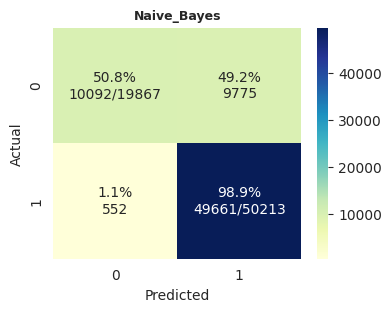

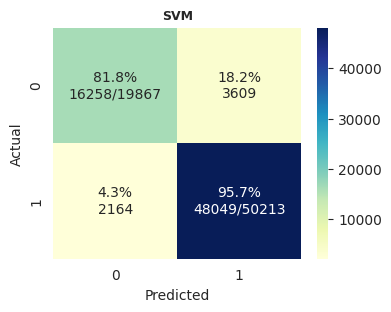

In [59]:
df_1_results = evaluate_dataset(df_1,train_X_tfidf, train_Y, test_X_tfidf, test_Y)

#### *Evaluation of df_2 : Tokenized text with stop word removal*

In [60]:
df_2.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'shorts', 'boat', 'rows', 'front', 'scree..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'tradition', 'family', 'values', 'modernity', 'new', 'medium', 'inscrutability', '..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['first', 'family', 'film', 'monsieur', 'lumi', 'wants', 'us', 'know', 'one', 'talented', 'filmm..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'back', 'commenting', 'silent', 'f..."


In [61]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_2, tfidf_vect)

            Naive_Bayes           SVM
TP         49494.000000  47978.000000
TN         10810.000000  16146.000000
FP          9057.000000   3721.000000
FN           719.000000   2235.000000
Accuracy       0.860502      0.915011
Precision      0.845314      0.928026
Recall         0.985681      0.955490
F1_score       0.910117      0.941557


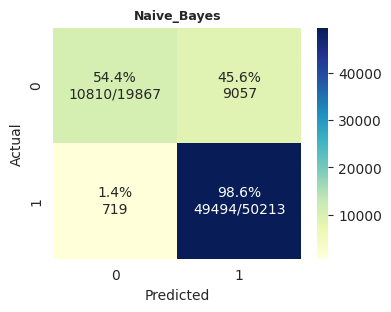

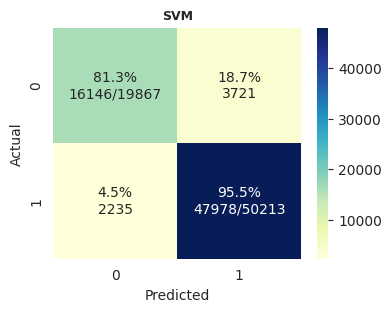

In [62]:
df_2_results = evaluate_dataset(df_2, train_X_tfidf, train_Y, test_X_tfidf, test_Y)

#### *Evaluation of df_3 : Tokenized text with lemmatisation*

In [63]:
df_3.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'be', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'value', 'the', 'modernity', 'of', ..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'want', 'u', 'to', '..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'get', 'ta', 'hurt', 'spoiler', 'spoiler', 'well', 'i', 'be', 'back', 'to', 'co..."


In [64]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_3, tfidf_vect)

            Naive_Bayes           SVM
TP         49695.000000  48011.000000
TN          9705.000000  16177.000000
FP         10162.000000   3690.000000
FN           518.000000   2202.000000
Accuracy       0.847603      0.915925
Precision      0.830229      0.928628
Recall         0.989684      0.956147
F1_score       0.902971      0.942187


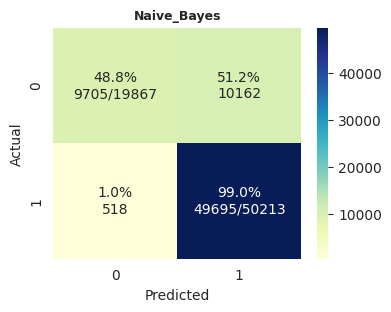

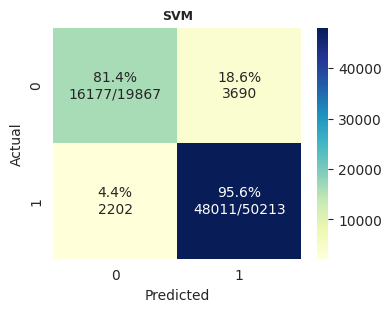

In [65]:
df_3_results = evaluate_dataset(df_3, train_X_tfidf, train_Y, test_X_tfidf, test_Y)

#### *Evaluation of df_4 : Tokenized text with lemmatisation and stop word removal*

In [66]:
df_4.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'short', 'boat', 'row', 'front', 'screen'..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'tradition', 'family', 'value', 'modernity', 'new', 'medium', 'inscrutability', 'n..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['first', 'family', 'film', 'monsieur', 'lumi', 'want', 'u', 'know', 'one', 'talented', 'filmmak..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'get', 'ta', 'hurt', 'spoiler', 'spoiler', 'well', 'back', 'comment', 'silent', 'film',..."


In [67]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_4, tfidf_vect)

            Naive_Bayes           SVM
TP         49512.000000  48003.000000
TN         10535.000000  16071.000000
FP          9332.000000   3796.000000
FN           701.000000   2210.000000
Accuracy       0.856835      0.914298
Precision      0.841411      0.926717
Recall         0.986039      0.955987
F1_score       0.908002      0.941125


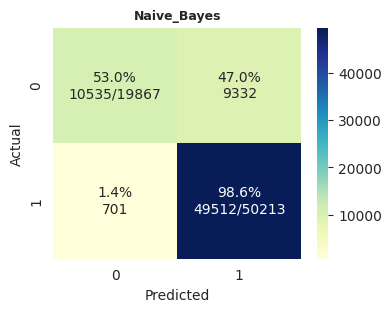

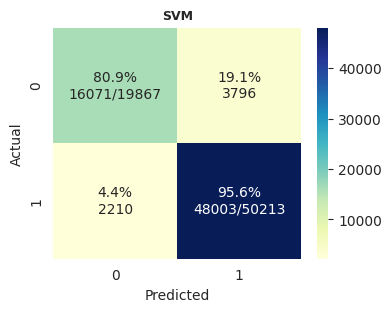

In [68]:
df_4_results = evaluate_dataset(df_4, train_X_tfidf, train_Y, test_X_tfidf, test_Y)

#### **Task 5**

Let us first group results together to make a better evaluation of the previous step. 

In [69]:
# Combine DataFrames into a single DataFrame with multi-indexing
results_dict = {'df_1': df_1_results, 'df_2': df_2_results, 'df_3': df_3_results, 'df_4': df_4_results}
results_combined = pd.concat(results_dict, axis=1)

As a refresher, the individual dataframes represent data as follows: <br>

- **df_1** : Dataframe where the review contains only tokenized text (removing all words that have punctuation or numerical data)
- **df_2** : Dataframe as df_1 but with stop word removal
- **df_3** : Dataframe as df_1 but with lemmatisation applied
- **df_4** : Dataframe as df_1 but with stop word removal and lemmatisation applied. 

In [70]:
results_combined

df_1                        df_2                \
            Naive_Bayes           SVM   Naive_Bayes           SVM   
TP         49661.000000  48049.000000  49494.000000  47978.000000   
TN         10092.000000  16258.000000  10810.000000  16146.000000   
FP          9775.000000   3609.000000   9057.000000   3721.000000   
FN           552.000000   2164.000000    719.000000   2235.000000   
Accuracy       0.852640      0.917623      0.860502      0.915011   
Precision      0.835537      0.930137      0.845314      0.928026   
Recall         0.989007      0.956904      0.985681      0.955490   
F1_score       0.905818      0.943330      0.910117      0.941557   

                   df_3                        df_4                
            Naive_Bayes           SVM   Naive_Bayes           SVM  
TP         49695.000000  48011.000000  49512.000000  48003.000000  
TN          9705.000000  16177.000000  10535.000000  16071.000000  
FP         10162.000000   3690.000000   9332.000000   3796.000000  
FN           518.000000   2202.000000    701.000000   2210.000000  
Accuracy       0.847603      0.915925      0.856835      0.914298  
Precision      0.830229      0.928628      0.841411      0.926717  
Recall         0.989684      0.956147      0.986039      0.955987  
F1_score       0.902971      0.942187      0.908002      0.941125

In [71]:
# Checking distribution of target feature in test set
np.unique(test_Y, return_counts=True)

(array([0, 1]), array([19867, 50213]))

*Observations of results between classifier models* <br>

Across all dataframe implementations, Support Vector Machine (SVM) models manage to predict a more balanced outcome. This can be inferred from the individual results of True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN) as well as the metrics for accuracy, precision, reclal and f1 score. While SVM models have scored a higher accuracy across the board, accuracy is not always a reliable metric, especially in imbalanced datasets, as high accuracy can sometimes be achieved by simply predicting the majority class. As a matter of fact, by simply predicting all instances from the test set (770080 records) as being positive reviews, the model would achieve 71.65% accuracy which of course would make that model not a very reliable one.  <br>

However SVM does perform better than Naive Bayes on all other fronts except of course recall, which is expected as indicated in Task 3 above. Due to the imbalance of the target feature, Naive Bayes has a higher count of predicted positive reviews, leading to a higher recall score. On the other hand, Naive Bayes scores badly on precision due to its higher incidence of false positives and false negatives. SVM performs quite consistently across all metrics. The F1 score being the harmonic mean between precision and recall balances out the disparity between precision and recall for Naive bayes but it is still lower than that achieved by the SVM model, indicating again the superiority and the better reliability of the latter model. <br>

*Observations of results across processed dataframes*

It can be noted that while the highest F1 score for SVM was obtained with the full dataset, where pre-processing consisted of removing numerical data and punctuation, removing stop words and lemmatizing the text did not have any major impact on the reported metrics. On the other hand the different pre-processing techniques adopted had a slight impact on the Naive Bayes model, with the additional removal of stop words have a positive increase in the F1 score for this model. 

*Using df_1 for a run with interchanged positive and negative reviews*

In [72]:
df_1.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


In [73]:
# Making a copy of df_1

df_1_inverted = df_1.copy()

In [74]:
# Changing the role of positive and negative reviews

# Defining a dictionary to map values
mapping = {0: 1, 1: 0}

# Inverting values in the 'sentiment' column
df_1_inverted['sentiment'] = df_1_inverted['sentiment'].map(mapping)

In [75]:
df_1_inverted.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",0,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",0,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",1,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",1,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",0,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


In [76]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_1_inverted, tfidf_vect)

            Naive_Bayes           SVM
TP         10150.000000  16292.000000
TN         49559.000000  48015.000000
FP           654.000000   2198.000000
FN          9717.000000   3575.000000
Accuracy       0.852012      0.917623
Precision      0.939467      0.881125
Recall         0.510897      0.820053
F1_score       0.661863      0.849493


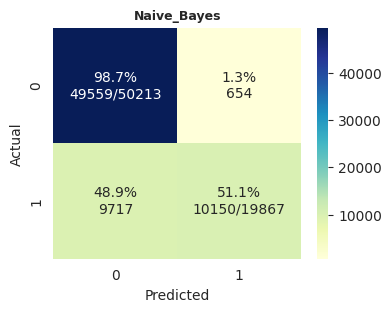

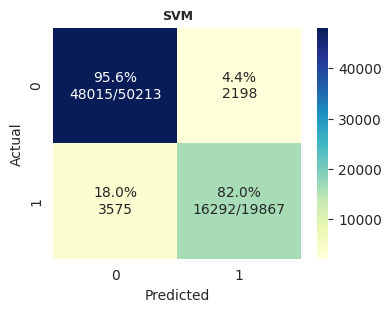

In [77]:
df_1_inverted_results = evaluate_dataset(df_1_inverted, train_X_tfidf, train_Y, test_X_tfidf, test_Y)

Let's combine the results datasets for a better analysis.

In [78]:
# Combine DataFrames into a single DataFrame with multi-indexing
results_dict_2 = {'Normal': df_1_results, 'Inverted': df_1_inverted_results}
results_combined_2 = pd.concat(results_dict_2, axis=1)

In [79]:
results_combined_2

Normal                    Inverted              
            Naive_Bayes           SVM   Naive_Bayes           SVM
TP         49661.000000  48049.000000  10150.000000  16292.000000
TN         10092.000000  16258.000000  49559.000000  48015.000000
FP          9775.000000   3609.000000    654.000000   2198.000000
FN           552.000000   2164.000000   9717.000000   3575.000000
Accuracy       0.852640      0.917623      0.852012      0.917623
Precision      0.835537      0.930137      0.939467      0.881125
Recall         0.989007      0.956904      0.510897      0.820053
F1_score       0.905818      0.943330      0.661863      0.849493

*Observations*

One can note that Accuracy remained practically the same under both scenarios. Being the proportion of correctly classified instances among total instances, TP+TN remained almost the same for both models, indicating that they both managed to retain the same level of correct predictions for positive and negative reviews. However in the new 'inverted' scenario one can notice the sharp drop in the recall score for Naive Bayes. Being the ratio of the true positive predictions among all actual positive instances in the dataset, Naive bayes predicted 10,150 as 1s (in this scenario being the negative reviews) out of a total of 19,867 1s (negative reviews) (TP+FN = 10,150 + 9717 = 19,867). This equates to the 0.510897 recall score, which highlights the inability of the Naive Bayes model to adequately predict the negative reviews. This also was reflected in the overall F1 score which decreased from 0.905818 to 0.661863. <br>

On the other hand SVM has shown that in predicting negative reviews it suffered a small decrease in the precision score as compared to predicting positive reviews. It correctly identified 16,292 out of 19,867 negative reviews (hence a recall score of 0.820053) but it also wrongly identified 2,198 reviews as being negative. It hence predicted 18,490 reviews as being negative reviews when only 16,292 of those were correct (hence resulting in a precision score of 0.881125). 

Overall however SVM remained the stronger and more reliable of the two models with an F1 score of 0.849493. This means that SVM was 9.95% less accurate (from an F1 score perspective) in identifying negative reviews than the previous model where it identified positive reviews. Naive bayes achieved an F1 score of 0.661863 under the 'inverted' scenario, which is 26.93% lower than the model under the scenario where the positive reviews were being predicted as 1s. 

#### **Task 6**

I will use the *imbalanced-learn* package which contains a random undersampler as one of its methods. Each dataset architecture will be re-evaluated after ensuring that the training set has equal representation from both classes. This will be achieved by randomly removing positive reviews until the amount of positive reviews matches that of the negative reviews. 

#### *Evaluation of df_1*

In [80]:
# Leaving sampling_strategy with default 'auto' to remove only from majority class
# Leaving replacement = False as default

# Initializing the random under sampler
rus = RandomUnderSampler(random_state=SEED)

In [81]:
df_1.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'is', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'values', 'the', 'modernity', 'of',..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'wants', 'us', 'to',..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'i', 'am', 'back', 'to', '..."


In [82]:
# Splitting dataset into training and testing
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_1, tfidf_vect)

In [83]:
# Resampling
train_X_res, train_Y_res = rus.fit_resample(train_X_tfidf, train_Y)

In [84]:
# Checking stratification of train_X_res

print(f'train_X_res has : {(np.unique(train_Y_res, return_counts=True)[1][0] / len(train_Y_res)):.2%} of negative reviews and : {(np.unique(train_Y_res, return_counts=True)[1][1] / len(train_Y_res)):.2%} of positive reviews')

train_X_res has : 50.00% of negative reviews and : 50.00% of positive reviews


            Naive_Bayes           SVM
TP         43379.000000  45512.000000
TN         16992.000000  17733.000000
FP          2875.000000   2134.000000
FN          6834.000000   4701.000000
Accuracy       0.861458      0.902469
Precision      0.937843      0.955211
Recall         0.863900      0.906379
F1_score       0.899354      0.930155


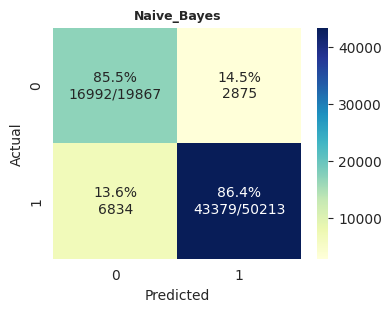

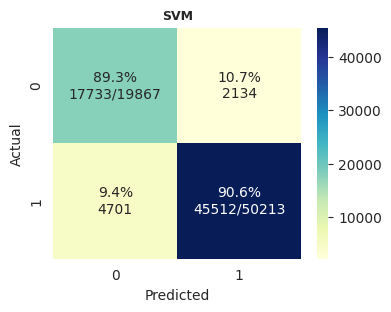

In [85]:
df_1_rus_results = evaluate_dataset(df_1, train_X_res, train_Y_res, test_X_tfidf, test_Y)

#### *Evaluation of df_2*

In [86]:
df_2.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'shorts', 'boat', 'rows', 'front', 'scree..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'tradition', 'family', 'values', 'modernity', 'new', 'medium', 'inscrutability', '..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['first', 'family', 'film', 'monsieur', 'lumi', 'wants', 'us', 'know', 'one', 'talented', 'filmm..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'got', 'ta', 'hurt', 'spoilers', 'spoilers', 'well', 'back', 'commenting', 'silent', 'f..."


In [87]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_2, tfidf_vect)

In [88]:
# Resampling
train_X_res, train_Y_res = rus.fit_resample(train_X_tfidf, train_Y)

            Naive_Bayes           SVM
TP         43575.000000  45390.000000
TN         17000.000000  17688.000000
FP          2867.000000   2179.000000
FN          6638.000000   4823.000000
Accuracy       0.864369      0.900086
Precision      0.938267      0.954193
Recall         0.867803      0.903949
F1_score       0.901661      0.928392


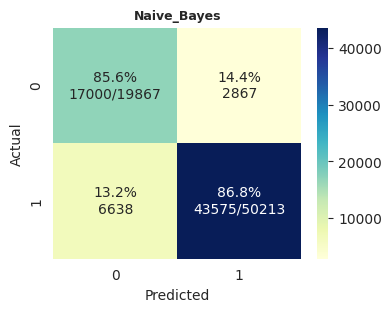

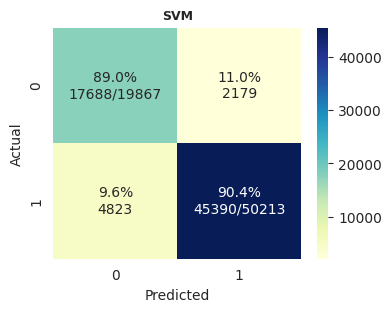

In [89]:
df_2_rus_results = evaluate_dataset(df_2, train_X_res, train_Y_res, test_X_tfidf, test_Y)

#### *Evaluation of df_3*

In [90]:
df_3.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['the', 'first', 'this', 'be', 'possibly', 'the', 'most', 'beautiful', 'of', 'the', 'early', 'lu..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'between', 'the', 'tradition', 'of', 'family', 'value', 'the', 'modernity', 'of', ..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['an', 'everyday', 'occurrence', 'for', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', '..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['the', 'first', 'family', 'film', 'monsieur', 'lumi', 're', 'not', 'only', 'want', 'u', 'to', '..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'that', 'get', 'ta', 'hurt', 'spoiler', 'spoiler', 'well', 'i', 'be', 'back', 'to', 'co..."


In [91]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_3, tfidf_vect)

In [92]:
# Resampling
train_X_res, train_Y_res = rus.fit_resample(train_X_tfidf, train_Y)

            Naive_Bayes           SVM
TP         43123.000000  45434.000000
TN         16985.000000  17752.000000
FP          2882.000000   2115.000000
FN          7090.000000   4779.000000
Accuracy       0.857705      0.901627
Precision      0.937355      0.955520
Recall         0.858802      0.904825
F1_score       0.896360      0.929482


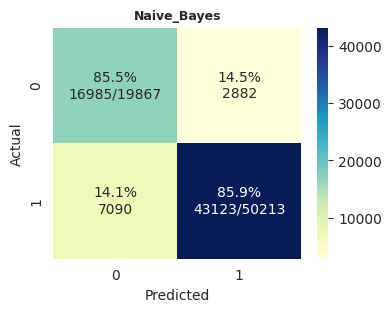

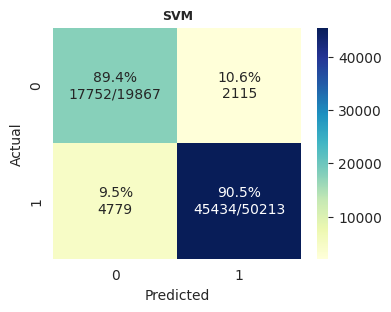

In [93]:
df_3_rus_results = evaluate_dataset(df_3, train_X_res, train_Y_res, test_X_tfidf, test_Y)

#### *Evaluation of df_4*

In [94]:
df_4.head()

,review,sentiment,final_review
0,"[the, first, art-film, ?, ., this, is, possibly, the, most, beautiful, of, the, early, lumiere, ...",1,"['first', 'possibly', 'beautiful', 'early', 'lumiere', 'short', 'boat', 'row', 'front', 'screen'..."
1,"[collision, between, the, tradition, of, family, values, ,, the, modernity, of, the, new, medium...",1,"['collision', 'tradition', 'family', 'value', 'modernity', 'new', 'medium', 'inscrutability', 'n..."
2,"[an, everyday, occurrence, for, posterity, ., louis, lumiere, 's, brother, ,, auguste, ,, and, h...",0,"['everyday', 'occurrence', 'posterity', 'louis', 'lumiere', 'brother', 'auguste', 'wife', 'sit',..."
3,"[the, first, family, film, ?, ., monsieur, lumi, re, not, only, wants, us, to, know, that, he, '...",0,"['first', 'family', 'film', 'monsieur', 'lumi', 'want', 'u', 'know', 'one', 'talented', 'filmmak..."
4,"[ouch, !, that, 's, got, ta, hurt, !, -lrb-, spoilers, -rrb-, ., spoilers, well, ,, i, am, back,...",1,"['ouch', 'get', 'ta', 'hurt', 'spoiler', 'spoiler', 'well', 'back', 'comment', 'silent', 'film',..."


In [95]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_4, tfidf_vect)

In [96]:
# Resampling
train_X_res, train_Y_res = rus.fit_resample(train_X_tfidf, train_Y)

            Naive_Bayes           SVM
TP         43429.000000  45265.000000
TN         16954.000000  17637.000000
FP          2913.000000   2230.000000
FN          6784.000000   4948.000000
Accuracy       0.861630      0.897574
Precision      0.937141      0.953048
Recall         0.864896      0.901460
F1_score       0.899570      0.926536


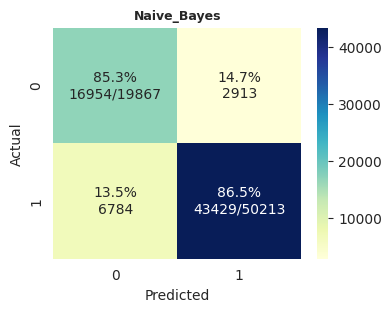

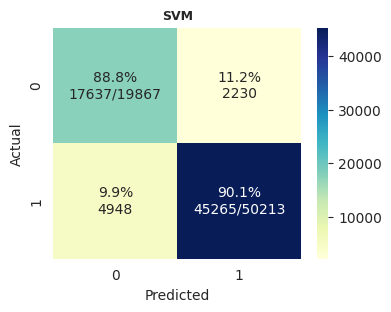

In [97]:
df_4_rus_results = evaluate_dataset(df_4, train_X_res, train_Y_res, test_X_tfidf, test_Y)

Now we combine results to make our observations:

In [98]:
# Combine DataFrames into a single DataFrame with multi-indexing
results_dict_rus = {'df_1_rus': df_1_rus_results, 'df_2_rus': df_2_rus_results, 'df_3_rus': df_3_rus_results, 'df_4_rus': df_4_rus_results}
results_combined_rus = pd.concat(results_dict_rus, axis=1)

In [99]:
results_combined_rus 

df_1_rus                    df_2_rus                \
            Naive_Bayes           SVM   Naive_Bayes           SVM   
TP         43379.000000  45512.000000  43575.000000  45390.000000   
TN         16992.000000  17733.000000  17000.000000  17688.000000   
FP          2875.000000   2134.000000   2867.000000   2179.000000   
FN          6834.000000   4701.000000   6638.000000   4823.000000   
Accuracy       0.861458      0.902469      0.864369      0.900086   
Precision      0.937843      0.955211      0.938267      0.954193   
Recall         0.863900      0.906379      0.867803      0.903949   
F1_score       0.899354      0.930155      0.901661      0.928392   

               df_3_rus                    df_4_rus                
            Naive_Bayes           SVM   Naive_Bayes           SVM  
TP         43123.000000  45434.000000  43429.000000  45265.000000  
TN         16985.000000  17752.000000  16954.000000  17637.000000  
FP          2882.000000   2115.000000   2913.000000   2230.000000  
FN          7090.000000   4779.000000   6784.000000   4948.000000  
Accuracy       0.857705      0.901627      0.861630      0.897574  
Precision      0.937355      0.955520      0.937141      0.953048  
Recall         0.858802      0.904825      0.864896      0.901460  
F1_score       0.896360      0.929482      0.899570      0.926536

In [100]:
# Checking how many positive and negative reviews did the classifiers predict

for dataset in results_combined_rus.columns.levels[0]:
    print()
    print(f'{dataset}')
    print('------')
    for classifier in results_combined_rus.columns.levels[1]:
        positive_reviews = results_combined_rus[dataset,classifier].loc[['TP','FP']].sum()
        negative_reviews = results_combined_rus[dataset,classifier].loc[['TN','FN']].sum()
        total_reviews = positive_reviews + negative_reviews
        specificity = results_combined_rus[dataset,classifier].loc['TN'] / results_combined_rus[dataset,classifier].loc[['TN','FP']].sum()
        print(f'{classifier} predicted {positive_reviews} positive reviews ({(positive_reviews / total_reviews):.2%}) and {negative_reviews} negative reviews ({(negative_reviews / total_reviews):.2%})') 
        print(f'True Negative Rate (Specificity): {specificity:.2%}')
        print()


df_1_rus
------
Naive_Bayes predicted 46254.0 positive reviews (66.00%) and 23826.0 negative reviews (34.00%)
True Negative Rate (Specificity): 85.53%

SVM predicted 47646.0 positive reviews (67.99%) and 22434.0 negative reviews (32.01%)
True Negative Rate (Specificity): 89.26%


df_2_rus
------
Naive_Bayes predicted 46442.0 positive reviews (66.27%) and 23638.0 negative reviews (33.73%)
True Negative Rate (Specificity): 85.57%

SVM predicted 47569.0 positive reviews (67.88%) and 22511.0 negative reviews (32.12%)
True Negative Rate (Specificity): 89.03%


df_3_rus
------
Naive_Bayes predicted 46005.0 positive reviews (65.65%) and 24075.0 negative reviews (34.35%)
True Negative Rate (Specificity): 85.49%

SVM predicted 47549.0 positive reviews (67.85%) and 22531.0 negative reviews (32.15%)
True Negative Rate (Specificity): 89.35%


df_4_rus
------
Naive_Bayes predicted 46342.0 positive reviews (66.13%) and 23738.0 negative reviews (33.87%)
True Negative Rate (Specificity): 85.34%

SVM 

In [101]:
results_combined

df_1                        df_2                \
            Naive_Bayes           SVM   Naive_Bayes           SVM   
TP         49661.000000  48049.000000  49494.000000  47978.000000   
TN         10092.000000  16258.000000  10810.000000  16146.000000   
FP          9775.000000   3609.000000   9057.000000   3721.000000   
FN           552.000000   2164.000000    719.000000   2235.000000   
Accuracy       0.852640      0.917623      0.860502      0.915011   
Precision      0.835537      0.930137      0.845314      0.928026   
Recall         0.989007      0.956904      0.985681      0.955490   
F1_score       0.905818      0.943330      0.910117      0.941557   

                   df_3                        df_4                
            Naive_Bayes           SVM   Naive_Bayes           SVM  
TP         49695.000000  48011.000000  49512.000000  48003.000000  
TN          9705.000000  16177.000000  10535.000000  16071.000000  
FP         10162.000000   3690.000000   9332.000000   3796.000000  
FN           518.000000   2202.000000    701.000000   2210.000000  
Accuracy       0.847603      0.915925      0.856835      0.914298  
Precision      0.830229      0.928628      0.841411      0.926717  
Recall         0.989684      0.956147      0.986039      0.955987  
F1_score       0.902971      0.942187      0.908002      0.941125

In [102]:
# Checking how many positive and negative reviews did the classifiers predict

for dataset in results_combined.columns.levels[0]:
    print()
    print(f'{dataset}')
    print('------')
    for classifier in results_combined.columns.levels[1]:
        positive_reviews = results_combined[dataset,classifier].loc[['TP','FP']].sum()
        negative_reviews = results_combined[dataset,classifier].loc[['TN','FN']].sum()
        total_reviews = positive_reviews + negative_reviews
        specificity = results_combined[dataset,classifier].loc['TN'] / results_combined[dataset,classifier].loc[['TN','FP']].sum()
        print(f'{classifier} predicted {positive_reviews} positive reviews ({(positive_reviews / total_reviews):.2%}) and {negative_reviews} negative reviews ({(negative_reviews / total_reviews):.2%})')                
        print(f'True Negative Rate (Specificity): {specificity:.2%}')
        print()
                                                               


df_1
------
Naive_Bayes predicted 59436.0 positive reviews (84.81%) and 10644.0 negative reviews (15.19%)
True Negative Rate (Specificity): 50.80%

SVM predicted 51658.0 positive reviews (73.71%) and 18422.0 negative reviews (26.29%)
True Negative Rate (Specificity): 81.83%


df_2
------
Naive_Bayes predicted 58551.0 positive reviews (83.55%) and 11529.0 negative reviews (16.45%)
True Negative Rate (Specificity): 54.41%

SVM predicted 51699.0 positive reviews (73.77%) and 18381.0 negative reviews (26.23%)
True Negative Rate (Specificity): 81.27%


df_3
------
Naive_Bayes predicted 59857.0 positive reviews (85.41%) and 10223.0 negative reviews (14.59%)
True Negative Rate (Specificity): 48.85%

SVM predicted 51701.0 positive reviews (73.77%) and 18379.0 negative reviews (26.23%)
True Negative Rate (Specificity): 81.43%


df_4
------
Naive_Bayes predicted 58844.0 positive reviews (83.97%) and 11236.0 negative reviews (16.03%)
True Negative Rate (Specificity): 53.03%

SVM predicted 51799.

In [103]:
results_combined['df_1','Naive_Bayes'].loc[['TP','FP']].sum()

59436.0

In [104]:
combined_results = pd.concat([results_combined.loc[['TP','TN','FP','FN']], results_combined_rus.loc[['TP','TN','FP','FN']]], axis=1)

In [105]:
combined_results

df_1                 df_2                 df_3                 df_4  \
   Naive_Bayes      SVM Naive_Bayes      SVM Naive_Bayes      SVM Naive_Bayes   
TP     49661.0  48049.0     49494.0  47978.0     49695.0  48011.0     49512.0   
TN     10092.0  16258.0     10810.0  16146.0      9705.0  16177.0     10535.0   
FP      9775.0   3609.0      9057.0   3721.0     10162.0   3690.0      9332.0   
FN       552.0   2164.0       719.0   2235.0       518.0   2202.0       701.0   

               df_1_rus             df_2_rus             df_3_rus           \
        SVM Naive_Bayes      SVM Naive_Bayes      SVM Naive_Bayes      SVM   
TP  48003.0     43379.0  45512.0     43575.0  45390.0     43123.0  45434.0   
TN  16071.0     16992.0  17733.0     17000.0  17688.0     16985.0  17752.0   
FP   3796.0      2875.0   2134.0      2867.0   2179.0      2882.0   2115.0   
FN   2210.0      6834.0   4701.0      6638.0   4823.0      7090.0   4779.0   

      df_4_rus           
   Naive_Bayes      SVM  
TP     43429.0  45265.0  
TN     16954.0  17637.0  
FP      2913.0   2230.0  
FN      6784.0   4948.0

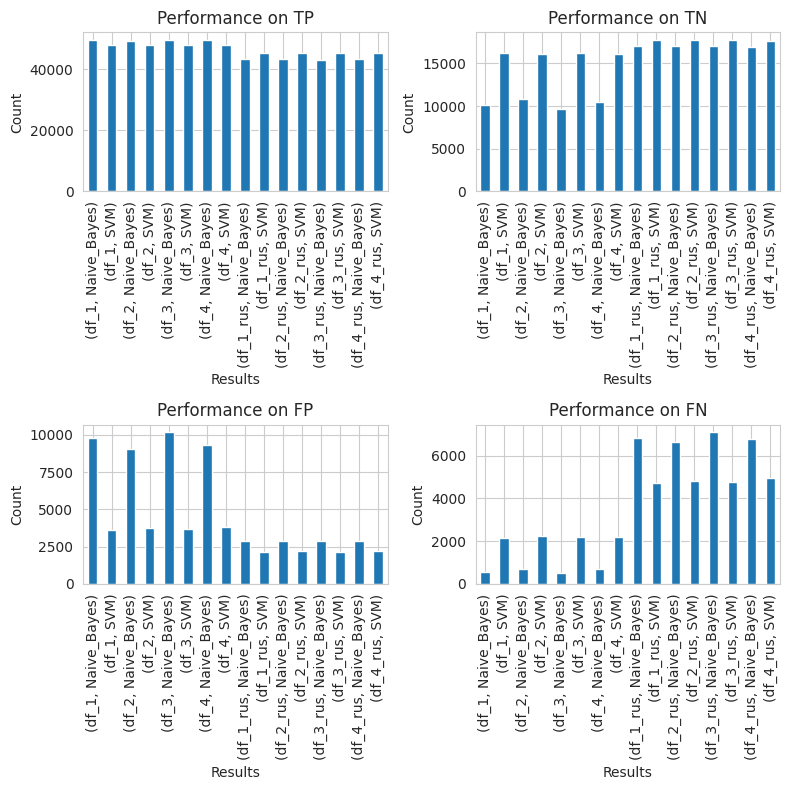

In [106]:
# adapted from Gemini proposed code
# These plots show the performance on each element of the confusion matrix for each model. 

n_rows = 2
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 8))

for i, col_name in enumerate(combined_results.T.columns):
    data_subset = combined_results.loc[col_name]
    data_subset.plot(kind='bar', stacked=False, ax=axes.flat[i])
    axes.flat[i].set_title(f'Performance on {col_name}')
    axes.flat[i].set_xlabel('Results')
    axes.flat[i].set_ylabel('Count')
    

plt.tight_layout()
plt.show()

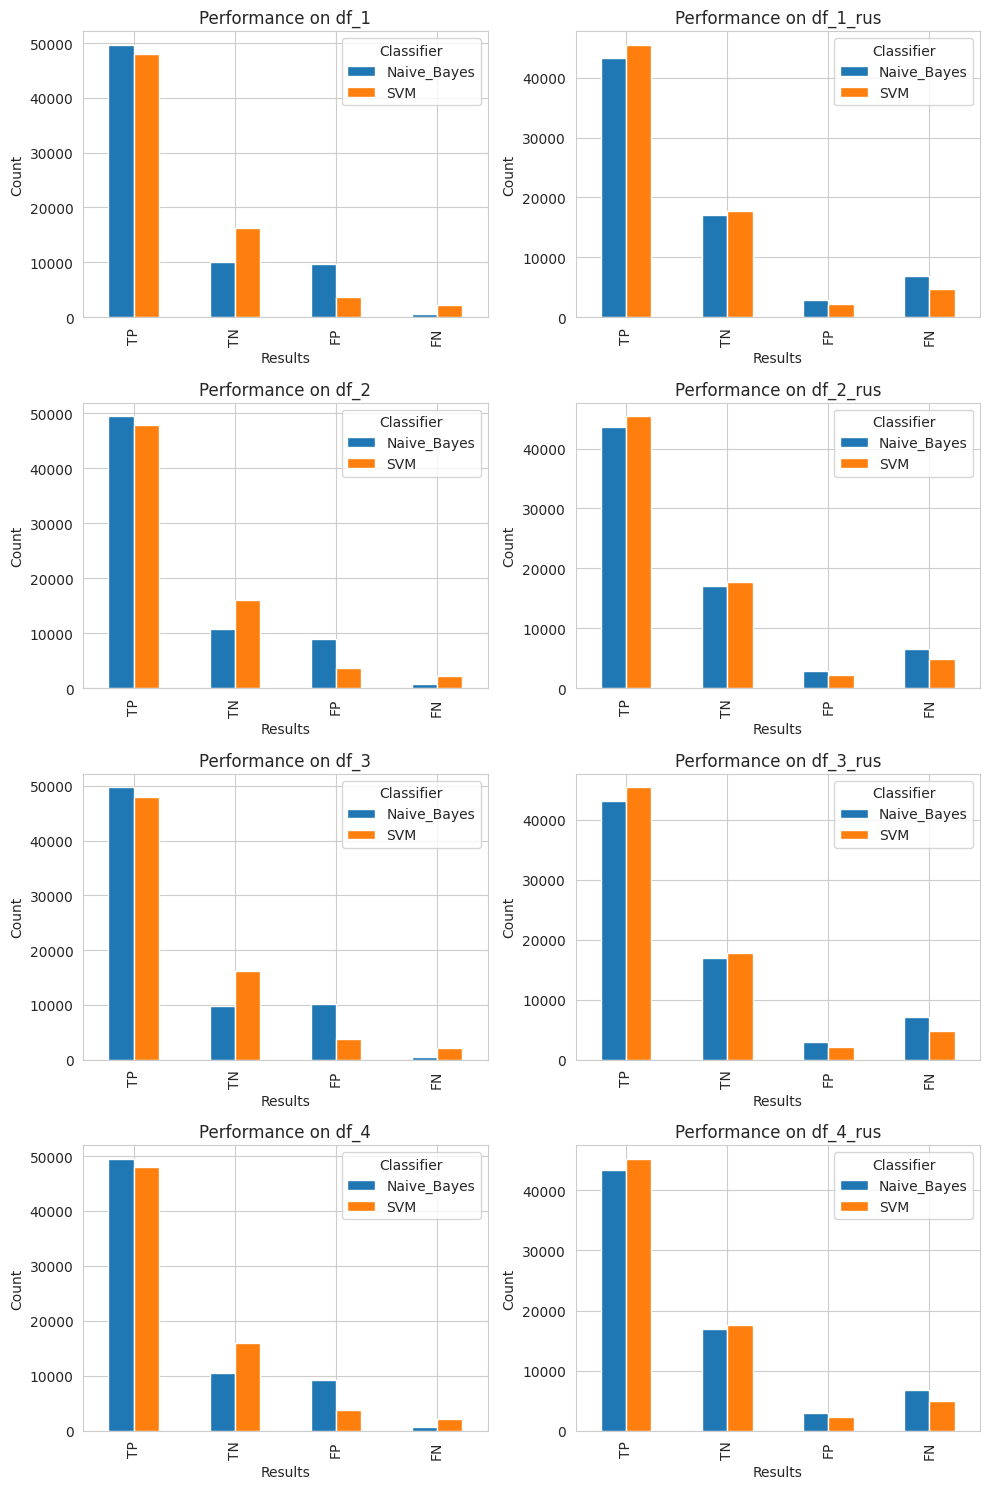

In [107]:
# adapted from Gemini proposed code
# These plots on the other hand visualize the combined components of the confusion matrix focusing on comparing the results for each model

n_rows = 4
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 15))

for i, df_name in enumerate(combined_results.columns.levels[0]):
    data_subset = combined_results.loc[:,df_name]
    data_subset.plot(kind='bar', stacked=False, ax=axes.flat[i])
    axes.flat[i].set_title(f'Performance on {df_name}')
    axes.flat[i].set_xlabel('Results')
    axes.flat[i].set_ylabel('Count')
    axes.flat[i].legend(title='Classifier')

plt.tight_layout()
plt.show()

*Observations* <br>

- The results indicate that by using random undersampling and balancing the positive and negative reviews for training, both classifiers have predicted less positive reviews, with Naive Bayes predicting on average 46,261 positive reviews and SVM predicting 47,677 positive reviews, also on average. This is in contrast with the process without undersampling where Naïve Bayes predicted 59,172 positive reviews on average and SVM predicted 51,714 positive reviews on average.  One can also note that the divergence in the predicted positive reviews between classifiers is lower when using random undersampling. <br>

- A similar but opposite observation can be made for the predicted negative reviews. Naïve Bayes predicted 23,819 negative reviews on average, while SVM predicted 22,515 negative reviews on average. This contrasts with the 10,908 average negative review predictions by Naïve Bayes and the 18,366 average negative review predictions by SVM. <br>

- Overall undersampling has regularized Naïve Bayes leading to closer predictions made, compared to those made by SVM.  One can note that without undersampling, SVM has managed to predict a closer positive to negative review prediction ratio as compared to the total dataset, while Naïve Bayes has benefited from the undersampling, leading to a closer positive to negative review prediction ratio. <br>

- An analysis of the individual components of the confusion matrix shows that while performance on True Positives remained more or less constant under both methods, Naïve Bayes performed much better in the performance on True Negatives, almost doubling its absolute True Negatives.  <br>

- Both classifiers scored better in the performance on False Positives, indicating that both classifiers reduced some of the bias that was prevalent on the positive reviews caused by the imbalance in the dataset.  <br>

- On the other hand both classifiers suffered the downside of a better performance on False Positives by having a large proportion of False Negatives when undersampling was used, in many cases more than double the absolute amount compared to when undersampling was not used. <br>

- Both classifiers scored a higher precision and hence in scenarios where one would want to achieve the highest proportion of correct positive reviews out of all positive reviews, the undersampling route would be better.  On the other hand if the aim is to achieve the highest proportion of correct positive reviews out of all samples, then the route without undersampling  would be better, as this achieves a higher recall across all pre-processing methods for both classifiers. <br>

- If one is interested in ensuring a more reliable prediction of the negative reviews, we must look at a slightly different ratio, that of True Negative Rate, also known as specificity, which is the ratio of TN/(TN+FP), or the correct predicted number of negative reviews (in our case) over the total number of actual negative reviews.  For both classifiers, across all pre-processing methodologies, the undersampling route provided the better results for this scenario. 




#### **Task 7**

In [108]:
# Re-initializing tfidf vectorizer to use 10,000 features

tfidf_vect_10k = TfidfVectorizer(max_features=10000)

I will re run the evaluation on *df_1* which is the dataset where punctuation and numerical data were removed. 

In [109]:
train_X_tfidf, train_Y, test_X_tfidf, test_Y = split_dataset(df_1, tfidf_vect_10k)

In [110]:
# Resampling
train_X_res, train_Y_res = rus.fit_resample(train_X_tfidf, train_Y)

            Naive_Bayes           SVM
TP         49476.000000  48028.000000
TN         11025.000000  16419.000000
FP          8842.000000   3448.000000
FN           737.000000   2185.000000
Accuracy       0.863313      0.919620
Precision      0.848383      0.933017
Recall         0.985323      0.956485
F1_score       0.911740      0.944606


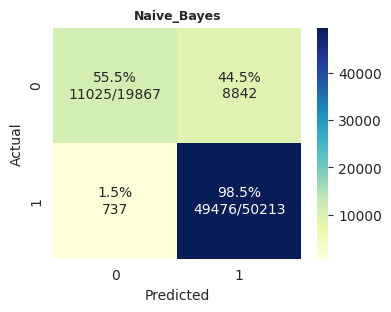

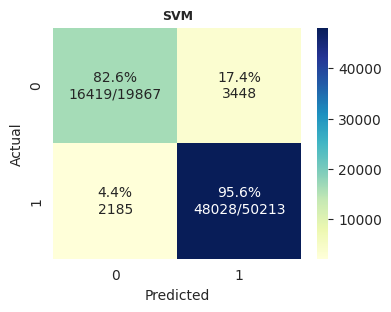

In [111]:
# Using all data
df_1_results_10k = evaluate_dataset(df_1, train_X_tfidf, train_Y, test_X_tfidf, test_Y)

            Naive_Bayes           SVM
TP         43128.000000  45561.000000
TN         17153.000000  17819.000000
FP          2714.000000   2048.000000
FN          7085.000000   4652.000000
Accuracy       0.860174      0.904395
Precision      0.940797      0.956983
Recall         0.858901      0.907355
F1_score       0.897986      0.931508


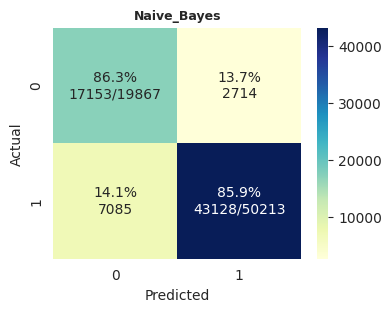

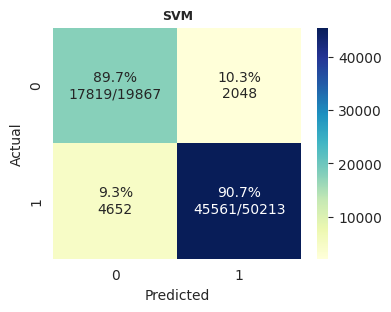

In [112]:
# Using undersampled data
df_1_rus_results_10k = evaluate_dataset(df_1, train_X_res, train_Y_res, test_X_tfidf, test_Y)

In [113]:
# Combine DataFrames into a single DataFrame with multi-indexing
results_dict_10k = {'All_data_10k': df_1_results_10k, 'Undersampling_10k': df_1_rus_results_10k,'All_data_5k': df_1_results, 'Undersampling_5k': df_1_rus_results}
results_combined_10k = pd.concat(results_dict_10k, axis=1)

In [114]:
results_combined_10k

All_data_10k               Undersampling_10k                \
            Naive_Bayes           SVM       Naive_Bayes           SVM   
TP         49476.000000  48028.000000      43128.000000  45561.000000   
TN         11025.000000  16419.000000      17153.000000  17819.000000   
FP          8842.000000   3448.000000       2714.000000   2048.000000   
FN           737.000000   2185.000000       7085.000000   4652.000000   
Accuracy       0.863313      0.919620          0.860174      0.904395   
Precision      0.848383      0.933017          0.940797      0.956983   
Recall         0.985323      0.956485          0.858901      0.907355   
F1_score       0.911740      0.944606          0.897986      0.931508   

            All_data_5k               Undersampling_5k                
            Naive_Bayes           SVM      Naive_Bayes           SVM  
TP         49661.000000  48049.000000     43379.000000  45512.000000  
TN         10092.000000  16258.000000     16992.000000  17733.000000  
FP          9775.000000   3609.000000      2875.000000   2134.000000  
FN           552.000000   2164.000000      6834.000000   4701.000000  
Accuracy       0.852640      0.917623         0.861458      0.902469  
Precision      0.835537      0.930137         0.937843      0.955211  
Recall         0.989007      0.956904         0.863900      0.906379  
F1_score       0.905818      0.943330         0.899354      0.930155

*Observations*

Overall using 10,000 features slightly improved metrics across both classifiers. This resulted in an improved F1_score for both classifiers, however this was achieved at the detriment of lower False Negatives results, given that all classifiers predicted slightly more incorrect negative reviews as compared to the using 5,000 features. 

#### **Task 8**

In their paper the authors presented a feature type named rating-based feature which they refer to as RbF for the task of document-level sentiment analysis. The contribution of this feature was applied to and evaluated on three datasets: <br>

- PL04 - 2,000 movie reviews produced by Pang and Lee (2004)
- IMDB11 - 50,000 movie reviews created by Maas et al. (2001)
- SAR14 - 233,600 movie reviews developed by the authors

All of these datasets contain either positive or negative reviews. While the first two datasets contained an equal number of positive and negative reviews, the one developed by the authors, which is the one used in this assignment, contained 167,378 positive reviews and 66,222 negative reviews, making this dataset an imbalanced one compared to the other two. The authors do not seem to have made any adjustments, corrections or even reference to this imbalance, which undoubtedly has a major influence on the chosen classifiers. <br>

Without going into much detail, the proposed RbF is simply a rating generated by a regression model trained on an independent dataset of movie reviews.  Whether or not this feature is of any added value is not within the scope of this short analysis. <br>

The training was performed using a linear kernel SVM classifier, which is the same algorithm adopted in our assignment. They did not apply any stop-word removal, stemming or lemmatization to the datasets. Assuming they performed punctuation and numerical data removal, this would be equivalent to the pre-processing we performed on the assignment dataset for Scenario 1, i.e. df_1 in my assignment.  The authors also adopted an N-gram filtering process whereby they retained only a selected number of N-grams (combination of unigrams, bigrams and trigrams) in the text. <br>

The authors provide their evaluation results on the PL04 and IMDB11 datasets using only the accuracy metric.  Using a confusion matrix terminology this is defined as the proportion of correctly classified instances out of the total instances., i.e. TP+TN/ TP+TN+FP+FN.  While this metric may provide a reasonable assessment of the performance of the classifier, it may not be ideal to just use one metric to evaluate a model, even if the dataset is balanced. This is because accuracy treats misclassifications equally. While we are analysing movie reviews, in real life scenarios, the cost of misclassifications can vary from one class to another, say for example if a model is used in medical treatment analysis.   Related to this downside is the inability of the accuracy metric to distinguish between false positives and false negatives, where precision and recall would be more adept as a metric. <br>

To be fair with the authors, the referred to papers by Pang and Lee and Maas et al. restrict their evaluation to the accuracy metric and hence it could be assumed that for comparison purposes, the authors chose to limit their evaluation to the accuracy metric. <br>

Nonetheless,  when it comes to the evaluation of their model on the SAR14 dataset, in which 71.65% of the reviews were positive and only 28.35% were negative, there was no indication of other metrics such as precision and recall. We have seen how such imbalance has impacted the model’s precision and recall scores, while still obtaining between 89% and 91% accuracy. Hence, by simply reporting 93.24% accuracy on their model, the authors have failed to evaluate whether their model was adequately balancing correct predictions for positive and negative reviews, or whether it was simply achieving a high recall and a low precision score.  <br>

On another note the authors have not reported how the datasets were split for training and testing. While they indicated a 10 fold cross validation approach, there was no indication of repeated tests using different split ratios for generalization. <br>

A proper evaluation of the model on all datasets would require a more in depth analysis of the predictions made by the model. Specificity ratios and a focus on the correct prediction of negative reviews on the SAR14 dataset would provide a clearer indication on the robustness of the model in making reasonable predictions for both majority and minority classes. 




 



---